In [16]:
import os
import torch
os.environ['TORCH'] = torch.__version__
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

Dataframe_Labels = pd.read_csv("../../BLCA_DATA/Workspace/labels_str.csv")
Dataframe_link = pd.read_csv("../../BLCA_DATA/Workspace/patient_norm.csv")
Dataframe_node= pd.read_csv("../../BLCA_DATA/Workspace/node_embedding.csv")

Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])

classes_dict = {0: 'LumP', 
                1: 'Ba/Sq', 
                2: 'LumU', 
                3: 'Stroma-rich', 
                4: 'LumNS', 
                5: 'NE-like'
}

def count_classes_weights(tensor):
    array = tensor.numpy()
    classes_tab = { 0: 0, 
                    1: 0,
                    2: 0, 
                    3: 0, 
                    4: 0,
                    5: 0
    }
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    used_classes = []
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *50
            used_classes.append(classes_dict[i])

    return used_classes, weight_dict

from sklearn.model_selection import train_test_split

node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

train_val_indices = [i for i in range(node_features.shape[0])]
_, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=0.2, 
    random_state=1234
)

x_train = node_features[train_val_indices]
x_test = node_features[test_indices]

patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])
similarity_threshold = 0.5  # Exemple de seuil de similarité

# Calculate the edges and attention ridges for training
edge_index_for_training = []
edge_attr_for_training = []
re_indexed_i = 0
re_indexed_j = 0
for i in range(len(train_val_indices)):
    for j in range(i+1, len(train_val_indices)):
        if patient_similarity[i, j] > similarity_threshold:
            edge_index_for_training.append([re_indexed_i, re_indexed_j])
            edge_attr_for_training.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
        re_indexed_j +=1
    re_indexed_i +=1
    re_indexed_j = 0

# Calculate the edges and attention ridges for testing
edge_index_for_testing = []
edge_attr_for_testing = []
re_indexed_i = 0
re_indexed_j = 0
for i in test_indices:
    for j in test_indices:
        if i >= j :
            break
        if patient_similarity[i, j] > similarity_threshold:
            edge_index_for_testing.append([re_indexed_i, re_indexed_j])
            edge_attr_for_testing.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
        re_indexed_j +=1
    re_indexed_i +=1
    re_indexed_j = 0

node_labels = Dataframe_Labels["class_int"].values
train_labels = torch.tensor(node_labels[train_val_indices], dtype=torch.long)
test_labels = torch.tensor(node_labels[test_indices], dtype=torch.long)

node_labels = torch.tensor(node_labels, dtype=torch.long)

used_classes, weight_dict = count_classes_weights(node_labels)
Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]
node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)

edge_features_for_training = torch.tensor(x_train, dtype=torch.float)
edge_index_for_training = torch.tensor(edge_index_for_training, dtype=torch.int64).t().contiguous()
edge_attr_for_training = torch.tensor(edge_attr_for_training, dtype=torch.float)
node_weights_for_training = node_weights[train_val_indices]

edge_features_for_testing = torch.tensor(x_test, dtype=torch.float)
edge_index_for_testing = torch.tensor(edge_index_for_testing, dtype=torch.int64).t().contiguous()
edge_attr_for_testing = torch.tensor(edge_attr_for_testing, dtype=torch.float)
node_weights_for_testing = node_weights[test_indices]

num_classes = 6
test_mask = torch.zeros(len(edge_features_for_training), dtype=torch.bool)
test_mask[test_indices] = True

train_val_data = Data(
    x=edge_features_for_training, 
    edge_index=edge_index_for_training, 
    edge_attr=edge_attr_for_training, 
    y=train_labels, 
    weights=node_weights_for_training, 
    num_classes=num_classes,
    num_nodes = len(edge_features_for_training),
    num_features = edge_features_for_training.shape[1],
    test_mask = test_mask
)

test_data = Data(
    x=edge_features_for_testing, 
    edge_index=edge_index_for_testing, 
    edge_attr=edge_attr_for_testing, 
    y=test_labels, 
    weights=node_weights_for_testing, 
    num_classes=num_classes, 
    num_nodes = len(edge_features_for_testing),
    num_features = edge_features_for_testing.shape[1]
    )

/tmp/ipykernel_69545/47490617.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features_for_training = torch.tensor(x_train, dtype=torch.float)
/tmp/ipykernel_69545/47490617.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features_for_testing = torch.tensor(x_test, dtype=torch.float)


In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import optuna
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads, data):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1))
        self.convs.append(GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1))
        
    def forward(self, x, edge_index, edge_attr):
        for conv in self.convs[:-1]:
            x = F.dropout(x, p=0.6, training=self.training)
            x = conv(x, edge_index, edge_attr)
            x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr)
        return x

def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

def dinstinction(data):
    train_val_indexes = torch.ones(data.num_nodes, dtype=torch.bool)
    for i in range(len(train_val_indexes)):
        if data.test_mask[i]:
            train_val_indexes[i] = False

    X=data.x[train_val_indexes]
    Y=data.y[train_val_indexes]
    return(X,Y)

def objective(trial, data = train_val_data, test_data = test_data):
    # Hyperparameters to be optimized
    hidden_channels = trial.suggest_int('hidden_channels', 16, 30)
    heads = trial.suggest_int('heads', 1, 16)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    all_test_acc = []
    
    data_X_for_Val, data_Y_for_val  = dinstinction(data)

    for fold, (_, val_index) in enumerate(skf.split(data_X_for_Val, data_Y_for_val)):

        train_index = [i for i in range(data.num_nodes)]
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[train_index] = True
        
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask[val_index] = True
        
        # Initialize model, optimizer, and loss function
        model = GATv2(hidden_channels=hidden_channels, heads=heads, data=data)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

        # Training loop
        for epoch in range(1, 1000):
            loss = train(model, data, optimizer)
            val_acc, _ = test(model, data, data.val_mask)
            train_acc, _ = test(model, data, data.train_mask)
            print(f'Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train {train_acc:.4f}, Val {val_acc:.4f}')

        # Evaluate on test set   
        test_mask = torch.ones(test_data.num_nodes, dtype=torch.bool)
        test_acc, _ = test(model, test_data, test_mask)

        # Store results
        all_test_acc.append(test_acc)

    # Calculate mean test accuracy for all folds
    mean_test_acc = np.mean(all_test_acc)
    storage[trial.number] = {"values": mean_test_acc, "heads": heads, "hidden_channels": hidden_channels}
    return mean_test_acc

storage = {}

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# Print the best parameters
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(storage)

[I 2024-07-14 22:03:14,617] A new study created in memory with name: no-name-ba1c44b3-326d-4708-9157-b18c5304faad


Fold: 1, Epoch: 001, Loss: 2.6318, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 002, Loss: 5.4608, Train 0.1337, Val 0.1385
Fold: 1, Epoch: 003, Loss: 3.3197, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 004, Loss: 2.9164, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 005, Loss: 3.7918, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 006, Loss: 3.1001, Train 0.1089, Val 0.0615
Fold: 1, Epoch: 007, Loss: 2.4963, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 008, Loss: 2.7575, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 009, Loss: 2.9815, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 010, Loss: 2.5297, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 011, Loss: 2.3259, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 012, Loss: 2.3408, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 013, Loss: 2.5021, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 014, Loss: 2.5161, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 015, Loss: 2.2968, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 016, Loss: 2.1752, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 017, Loss: 2.3291, Train

[I 2024-07-14 22:29:51,701] Trial 0 finished with value: 0.24691358024691357 and parameters: {'hidden_channels': 22, 'heads': 12}. Best is trial 0 with value: 0.24691358024691357.


Fold: 5, Epoch: 999, Loss: 0.2827, Train 0.1955, Val 0.2500
Fold: 1, Epoch: 001, Loss: 2.7025, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 002, Loss: 5.0333, Train 0.3713, Val 0.3538
Fold: 1, Epoch: 003, Loss: 3.0025, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 004, Loss: 4.0523, Train 0.1312, Val 0.1385
Fold: 1, Epoch: 005, Loss: 3.8551, Train 0.1312, Val 0.1385
Fold: 1, Epoch: 006, Loss: 3.9654, Train 0.1312, Val 0.1385
Fold: 1, Epoch: 007, Loss: 2.7595, Train 0.3119, Val 0.3692
Fold: 1, Epoch: 008, Loss: 2.3593, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 009, Loss: 2.5280, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 010, Loss: 2.8683, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 011, Loss: 2.7766, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 012, Loss: 3.1365, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 013, Loss: 2.9956, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 014, Loss: 3.0888, Train 0.3787, Val 0.3538
Fold: 1, Epoch: 015, Loss: 2.5373, Train 0.3144, Val 0.3692
Fold: 1, Epoch: 016, Loss: 2.3925, Train

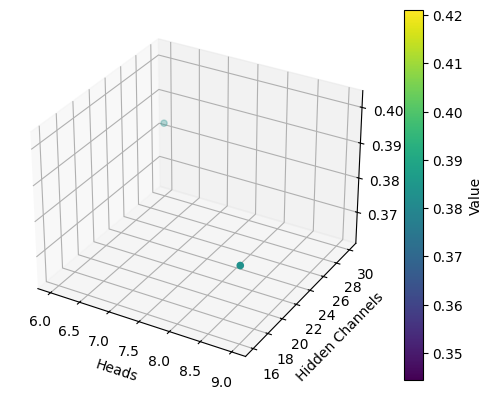

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Préparation des données pour le plot en 3D
heads = [storage[i]['heads'] for i in storage]
hidden_channels = [storage[i]['hidden_channels'] for i in storage]
values = [storage[i]['values'] for i in storage]

# Création du graphique en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(heads, hidden_channels, values, c=values, cmap='viridis', marker='o')

ax.set_xlabel('Heads')
ax.set_ylabel('Hidden Channels')
ax.set_zlabel('Value')

plt.colorbar(sc, label='Value')
plt.show()